In [86]:
import csv
import os

import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

In [ ]:
# NOT WORKING AT THE MOMENT :) 

In [120]:
def mat_exp(omega):
    if len(omega) != 3:
        raise ValueError("tangent vector must have length 3")

    def hat(v):
        v = v.flatten()
        R = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        return R

    angle = np.linalg.norm(omega)

    # Near phi==0, use first order Taylor expansion
    if angle < 1e-10:
        return np.identity(3) + hat(omega)

    axis = omega / angle
    s = np.sin(angle)
    c = np.cos(angle)

    return c * np.identity(3) + (1 - c) * np.outer(axis, axis) + s * hat(axis)

In [141]:
# Propagate dynamics
# params
mass = 0.875
Ct = 1.56252e-06
Cd = 8.06428e-05
Cr = 0.000001
Cm = 0.13 # 0.022 # Gazebo
J = np.diag([.03, .03, .06])
arm_length = 0.15
h = arm_length * np.cos(np.pi / 4)
r = np.array([[h, -h, -h, h], [-h, -h, h, h], [0., 0., 0., 0.]])
gravity = np.array([0.0, 0.0, 9.81])

# s = [p, q, v, omega], dims: (13,)
# accels = [lin_acc, ang_acc]

## Inputs
# s0: State at t0
# accels0: linear and angular accel at t0
# inputs: [w1^2, w2^2, w3^2, w4^2]
# dt: = delta time
## Output
#
def updateState(s0, accels0, inputs, dt = 0.01):
    thrust0 = accels0[0:3] + gravity
    e_zb = thrust0 / np.linalg.norm(thrust0)
    
    # debug
    '''print('e_zb')
    print(e_zb)
    print('Rz')
    print(Quaternion(s0[3:7]).rotation_matrix[:,2])'''
    e_zb = Quaternion(s0[3:7]).rotation_matrix[:,2]
    # end
    
    vA = s0[7:10]
    vA_perp = vA - (vA.dot(e_zb)) * e_zb
    
    Ft = np.zeros((3,4))
    Fd = np.zeros((3,4))
    Mr = np.zeros((3,4))
    Md = np.zeros((3,4))
    for i in range(4):
        Ft[:,i] = inputs[i] * inputs[i] * Ct * e_zb
        #Fd[:,i] = inputs[i] * Cd * vA_perp
        Mr[:,i] = inputs[i] * Cr * vA_perp
        Md[:,i] = -1.0 * Cm * Ft[:,i]
        
    # compute lin and ang accels
    R = Quaternion(s0[3:7]).rotation_matrix
    
    # debug
    '''print('Ft')
    print(Ft)
    print('Fd')
    print(Fd)'''
    # end
    
    a = (1.0/mass) * np.dot(R, np.sum(Ft+Fd, axis=1)) - gravity
    F_cross_r = np.zeros((3,))
    for i in range(4):
        F_cross_r += np.cross(Ft[:,i]+Fd[:,i], r[:,i])
    omega_dot = np.sum(Mr+Md, axis=1) + F_cross_r - np.cross(s0[10:], J) @ s0[10:]
    omega_dot = np.dot(np.linalg.inv(J), omega_dot)
    
    # update dynamics
    p0 = s0[0:3]
    R0 = Quaternion(s0[3:7]).rotation_matrix
    v0 = s0[7:10]
    omega0 = s0[10:]
    
    v1 = v0 + dt * a
    p1 = p0 + dt * v1
    omega1 = omega0 + dt*omega_dot
    dR = mat_exp(omega1 * dt)
    R1 = np.dot(R0, dR)
    q1 = Quaternion(matrix=R1)
    q1_arr = np.array([q1[0], q1[1], q1[2], q1[3]])
    
    # debug
    '''print('p1')
    print(p1)
    print('q1')
    print(q1_arr)
    print('v1')
    print(v1)
    print('omega1')
    print(omega1)'''
    
    #print('acc')
    #print(a)
    '''print('omega_dot')
    print(omega_dot)'''
    # end
    
    s1 = np.concatenate((p1, q1_arr, v1, omega1))
    accels1 = np.concatenate((a, omega_dot))
    
    return s1, accels1

In [142]:
# load data from csv
ref_traj_csv = '/home/giovanni/TLIO/data/tracking_arena_data/29July21/2021-02-03-13-43-38_traj.csv'

with open(ref_traj_csv, 'r') as csvfile:
    traj_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    traj_array = np.array(list(traj_reader))[1:]
    traj_from_csv = traj_array.astype(float)

In [144]:
# magic coeff.
alpha = 10.28

# Initial condition
p0 = np.array([traj_from_csv[0,1:4]]).flatten()
q0 = np.array(traj_from_csv[0,4:8]).flatten()
v0 = np.array([traj_from_csv[0,8:11]]).flatten()
omega0 = np.array([traj_from_csv[0,11:14]]).flatten()

acc0 = np.array([traj_from_csv[0,14:17]]).flatten()

# debug
acc0 = np.zeros((3,))
q0 = np.array([1.,0.,0.,0.])
# end

omega_dot0 = np.array([traj_from_csv[0,17:20]]).flatten()

s0 = np.concatenate((p0, q0, v0, omega0))
accels0 = np.concatenate((acc0, omega_dot0))

# debug
print('p0')
print(p0)
print('q0')
print(q0)
print('v0')
print(v0)
print('omega0')
print(omega0)
print('acc')
print(acc0)
print('omega_dot')
print(omega_dot0)
# end

# Propagate
pos_sim = [s0[0:3]]
pos_ref = [traj_from_csv[0, 1:4]]
for i, t in enumerate(traj_from_csv[1:]):
    #debug
    #print('---- %d -----' %i)
    
    pos_ref.append(t[1:4])
    
    # inputs = rotors speed squared
    inputs = np.sqrt(np.array([traj_from_csv[0,20:24]]).flatten() * (alpha/Ct))
    s1, accels1 = updateState(s0, accels0, inputs)
    
    pos_sim.append(s1[0:3])
    
    s0 = s1
    accels0 = accels1
    
    # debug
    '''if i == 100:
        break'''
    # end

pos_ref = np.asarray(pos_ref)
pos_sim = np.asarray(pos_sim)

p0
[3.5 5.  2. ]
q0
[1. 0. 0. 0.]
v0
[-0.  0.  0.]
omega0
[ 2.74461970e-03 -2.17755162e-03 -1.11447106e-06]
acc
[0. 0. 0.]
omega_dot
[3.39040369e-03 8.12261875e-03 5.58688373e-05]


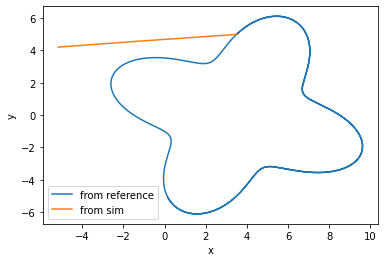

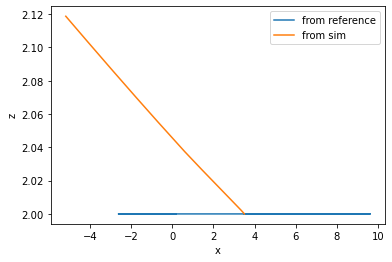

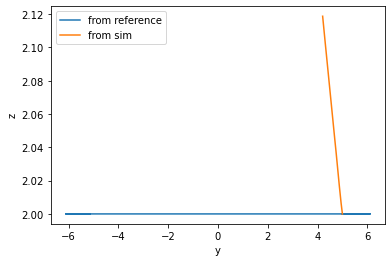

In [145]:
ts = traj_from_csv[:,0]

plt.figure('XY traj')
plt.plot(pos_ref[:,0], pos_ref[:,1], label='from reference')
plt.plot(pos_sim[:,0], pos_sim[:,1], label='from sim')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.figure('XZ traj')
plt.plot(pos_ref[:,0], pos_ref[:,2], label='from reference')
plt.plot(pos_sim[:,0], pos_sim[:,2], label='from sim')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.figure('YZ traj')
plt.plot(pos_ref[:,1], pos_ref[:,2], label='from reference')
plt.plot(pos_sim[:,1], pos_sim[:,2], label='from sim')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

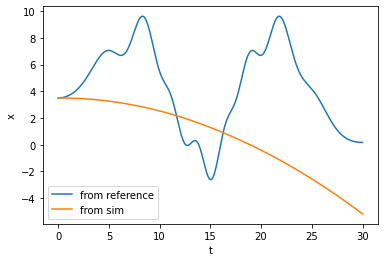

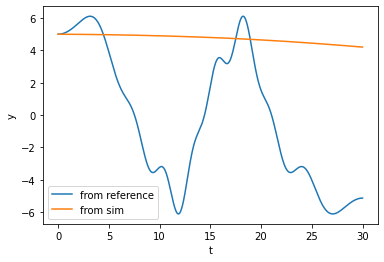

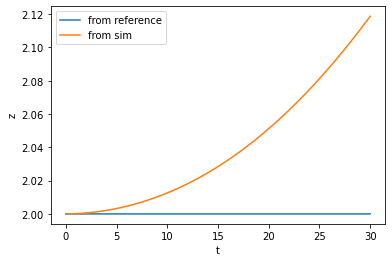

In [146]:
plt.figure('X time')
plt.plot(ts, pos_ref[:,0], label='from reference')
plt.plot(ts, pos_sim[:,0], label='from sim')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.figure('Y time')
plt.plot(ts, pos_ref[:,1], label='from reference')
plt.plot(ts, pos_sim[:,1], label='from sim')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

plt.figure('Z time')
plt.plot(ts, pos_ref[:,2], label='from reference')
plt.plot(ts, pos_sim[:,2], label='from sim')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()